-----------

# TRABAJO PRACTICO FINAL

### DIGITAL HOUSE: Data Science
### Junio 2022

<br>

## GRUPO 1
- Integrantes:
    - Gonzalo Barbot - PM: Project Manager
    - Agustin Stigliano - CDM: Code Development Manager
    - Fernando Dupont - PDM: Presentation Development Manager
    
<br>

## TEMA: Pronósticos sobre Series Temporales
<br>

-----

# NOTEBOOK MACHINE LEARNING:


### IMPORTACION DE LIBRERIAS

Activación de logging

In [43]:
import SmartSeries
import APP_REG_LOG_EST as reg
import APP_ARIMA as arima
import APP_XGBOOST as xgb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import pickle
import time

import logging
import datetime as dt
formatter = '%(levelname)s:\n %(message)s | %(asctime)s\n'#| line %(lineno)d\n'
logging.basicConfig(filename='logfile_Machine_learning.log', level=logging.INFO, force=True, filemode='w', **{'format':formatter})
logger = logging.getLogger()

In [44]:
# MODULO DE ARRANQUE
import SmartPandas
from SmartPandas import x_en
def x():
    return x_en('log_ML')

def show_df(df):
    display (df)
    print (df.index)
    display (SmartPandas.data_info(df))


log_message  = '{}) STARTING PROGRAM'
logger.info(log_message.format(x()))
SmartSeries.apply_dark_mode()

### CARGA DEL DATASET: TIME SERIE

In [45]:
# MODULO DE CARGA DE DATOS
file_name = 'df_targets.csv'
df = SmartSeries.load_dataset(file_name, freq='D', dropnan=False, fillnan=True)
log_message = '{}) LOADING FUNCTION: load_dataset(): se carga el dataset llamado "{}"'
logger.info(log_message.format(x(), file_name))


Serie de tiempo: date

Cantidad de NaNs en: 
Grocery             0
Pharmaceutical      0
Natural_Products    0
Bakery              1
Meat                1
NaNs imputados: método "backfill"


In [46]:
show_df(df)

,Grocery,Pharmaceutical,Natural_Products,Bakery,Meat
date,,,,,
2012-04-10,125.835760,349.128351,101.781519,161.637857,353.698462
2012-04-11,146.691058,179.865346,101.030875,123.934848,222.319762
2012-04-12,164.758837,195.612941,114.137453,158.606944,521.658136
2012-04-13,152.669070,169.872827,106.682081,182.599318,521.257895
2012-04-14,126.721540,198.341983,126.068018,125.618571,327.602143
...,...,...,...,...,...
2013-06-26,112.263581,292.195754,103.016559,149.655882,223.138889
2013-06-27,120.195221,222.045030,100.582025,151.791714,392.826829
2013-06-28,130.841667,189.297044,87.684000,116.581364,228.294590


DatetimeIndex(['2012-04-10', '2012-04-11', '2012-04-12', '2012-04-13',
               '2012-04-14', '2012-04-15', '2012-04-16', '2012-04-17',
               '2012-04-18', '2012-04-19',
               ...
               '2013-06-21', '2013-06-22', '2013-06-23', '2013-06-24',
               '2013-06-25', '2013-06-26', '2013-06-27', '2013-06-28',
               '2013-06-29', '2013-06-30'],
              dtype='datetime64[ns]', name='date', length=447, freq='D')


info de data,columna,Nan,pct_nan,dtype,count,pct_reg,count_unique
0,Bakery,0,0.0,float64,447,100.0,446
1,Meat,0,0.0,float64,447,100.0,446
2,Grocery,0,0.0,float64,447,100.0,447
3,Pharmaceutical,0,0.0,float64,447,100.0,447
4,Natural_Products,0,0.0,float64,447,100.0,447


In [17]:
# lo que hacemos todos siempre: Chequear 2 veces las cosas
df.isna().sum()

Grocery             0
Pharmaceutical      0
Natural_Products    0
Bakery              0
Meat                0
dtype: int64

### CREACION DE LAS MATRICES TARGETS

<b>Vectores SmartSerie's

In [18]:
# CREAMOS LOS VECTORES TIME SERIE
labels_category = df.columns.values

vector = SmartSeries.VectorBuilder(df)
vectores = {}
for elemento in labels_category:
    vector.create(elemento)
    vector.treatment()
    vector.dummy('W')
    vectores[elemento] = vector.vector


Serie de tiempo: date



In [19]:
# interactive display
vector.targets
vectores.keys()
vectores['Pharmaceutical'];# vectores['Pharmaceutical'].index

# EJECUCION MANUAL DEL CODIGO

## FORECAST 1: TEST SET

### MODELO 1: reg_log_est

Luego de haber seleccionado el "umbral" done se selecciona la categoria, se procede a evaluar un train test split en funcion del "umbral_2".

Seguido de eso, se entrenan 6 modelos de regresion:

    - regresion lineal con transformacion logartimica y estacionalidad
    - regresion cuadratica con transformacion logartimica y estacionalidad
    - regresion lineal con transformacion logartimica
    - regresion cuadratica con transformacion logaritmica
    - regresion lineal
    - regresion cuadratica

Luego de instanciar, entrenar y predecir todos los modelos se identifica el mejor score, se ejecuta una funcion que selecciona el modelo que mejor ajusta por medio de una funcion que extrae el modelo entrenado de una lista.

In [20]:
def check_optimized_model(results, umbral):
    return results.loc[results[umbral].astype('float64').idxmin()].to_frame().T

def get_optimized_model(modelos, scores):
    return modelos[pd.Series(scores).idxmin()]

DEFINE LOS UMBRALES

In [21]:
log_message = '{}) ELIGE LAS VARIABLES PARA FORECAST'
logger.critical(log_message.format(x()))
#####################################################################################################
umbral = 'Bakery' # category to implement forecast
umbral_2 = 60 # test_size for train test split
umbral_3 = 'RMSE' # es para evitar fallas


muestra = vectores[umbral]
modelos_reg_log_est = reg.available_models()
nombre_modelos = reg.def_models()

#train test split: 60 dias = 2 meses
df_train, df_test = train_test_split(muestra, shuffle=False, test_size=umbral_2)

# iteracion para instanciar el modelo de statsmodels
for i in range(len(modelos_reg_log_est)):
    modelos_reg_log_est[i] = modelos_reg_log_est[i](muestra, vector, umbral)

# iteracion para entrenar los modelos_reg_log_est instanciados, y almancenar el score de las predicciones
scores = []
for i in range(len(modelos_reg_log_est)):
    modelos_reg_log_est[i] = modelos_reg_log_est[i].fit()
    y_pred = modelos_reg_log_est[i].predict(df_test)
    if i <= 3: y_pred = np.exp(y_pred) # los primeros 4 modelos_reg_log_est predicen sobre el logartimo del target
    scores.append(np.sqrt(mean_squared_error(df_test[vector.target], y_pred)))

#resultados = {}
results_reg_log_est = pd.DataFrame([nombre_modelos, scores]).T
log_message = '{}) ALTERATION OF VARIABLE TYPE: (corregido en def check_optimized_model) Cuando creo un dataset a partir de un conjunto de listas, los valores float me los convierte en series tipo "Object"'
logger.warning(log_message.format(x()))
results_reg_log_est.columns = ['Modelo', umbral_3]

log_message = '{}) implementando la funcion "check_optimized_model" tiene hardseteado la label "RMSE", definida previamente en la linea superior a esta'
# aca vamos a usar un dataset aparte, usando "nombre_modelos"
optimized_umbral_model = get_optimized_model(modelos_reg_log_est, scores)

In [22]:
check_optimized_model(results_reg_log_est, umbral_3)

,Modelo,RMSE
1,log_trend_est_sq,66.2502


### Dickey-Fuller test for ARIMA optimization



A continuacion aplicaremos un proceso de diferenciacion sobre la prediccion del modelo anterior respecto al logaritmo de la variable target.

Se define el resultado como "residuo" de la prediccion reg_log_est, y se lo evalua visualmente para eventualmente aplicar un modelo ARIMA si se diera el caso y se quiera optimizar las predicciones

c:\Users\aguST\anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


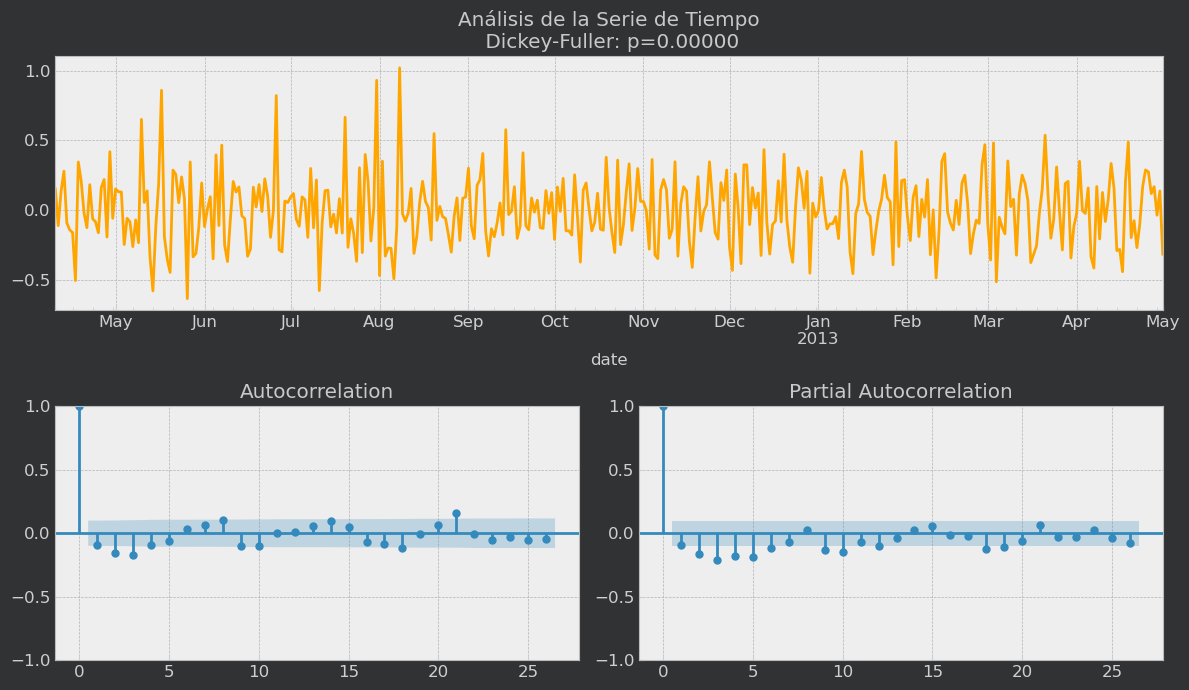

In [23]:
# proceso de diferenciacion 1: residuos entre target real y prediccion modelo reg_log_est
y_test = df_train['log_'+umbral] 
y_real = df_train[umbral]

y_pred = optimized_umbral_model.predict(df_train)

residuo = y_test - y_pred

arima.params_set_plot(residuo)

In [24]:
# from statsmodels.tsa.arima.model import ARIMA# hasta ahora no encontramos contexto para aplicar ARIMA

# EJECUCION MANUAL DEL CODIGO

## FORECAST 1: TEST SET

### MODELO 2: xgboost

In [25]:
error, df_test_xgboost, df_pred_xgboost = xgb.walk_forward_validation(muestra['log_'+umbral].to_frame(), n_test=umbral_2)

df_pred_xgboost.columns = [umbral]
df_test_xgboost.columns = [umbral]

df_pred_xgboost.set_index(df_test.index, inplace=True)
df_test_xgboost.set_index(df_test.index, inplace=True)

y_pred_real = np.exp(df_pred_xgboost)
y_test_real = np.exp(df_test_xgboost)

100%|██████████| 60/60 [00:18<00:00,  3.17it/s]


In [26]:
RMSE = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
line = 'xgboost RMSE prediction = {}'
print (line.format(RMSE))

xgboost RMSE prediction = 87.85783217931315


In [27]:
xgboost_optimize = False
if xgboost_optimize:
    xgboost_scores = {}
    xgboost_predictions = {}
    for i, elemento in enumerate(range(25,76,5)):
        error, df_test_xgboost, df_pred_xgboost = xgb.walk_forward_validation(muestra[umbral].to_frame(), n_test=elemento)
        xgboost_scores['RMSE'] = {f'{elemento}_steps': [np.sqrt(error)]}
        xgboost_predictions
    pd.DataFrame(xgboost_scores)

### PROYECCION

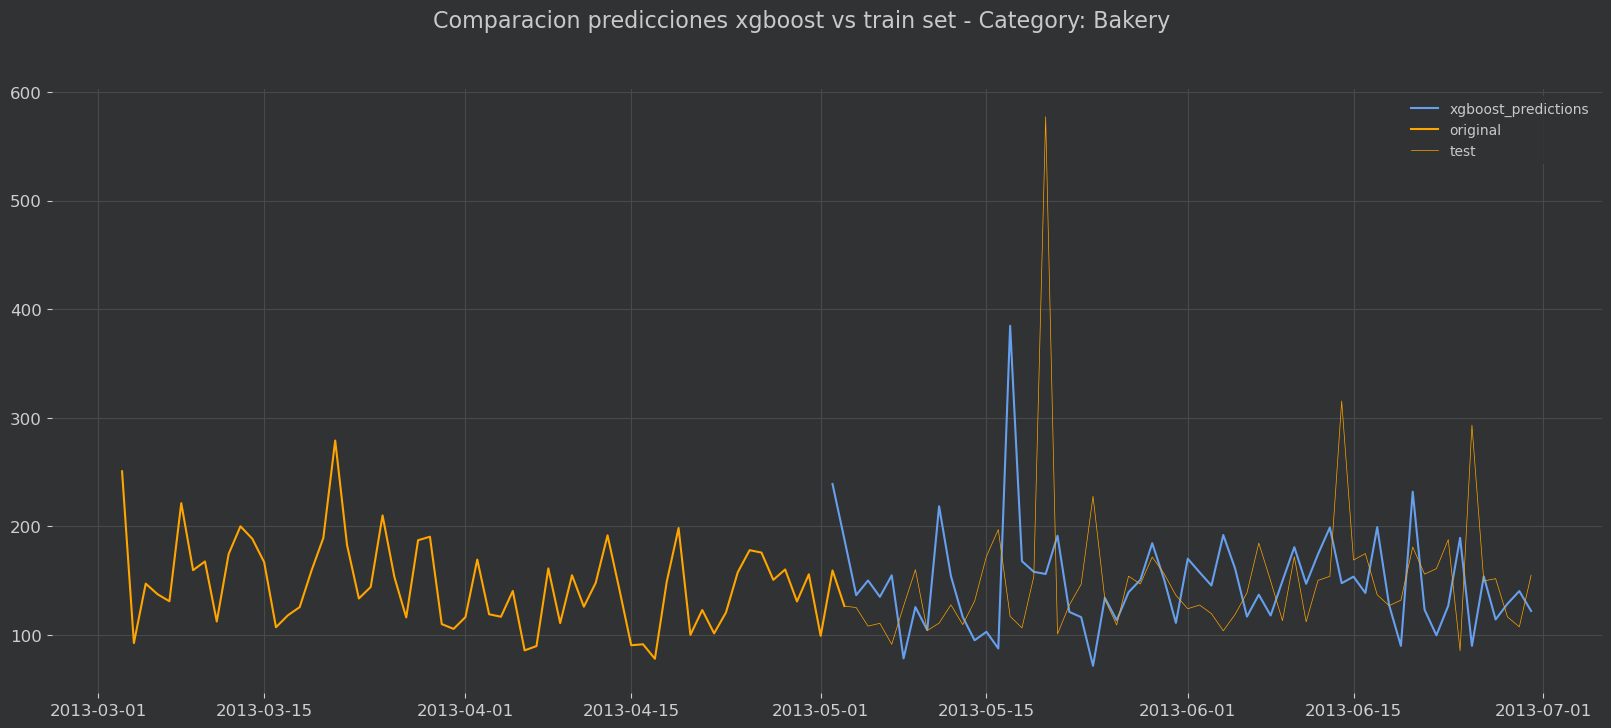

In [28]:
data_view = muestra[[umbral]].iloc[umbral_2*-2:-(umbral_2 + int(-0.0334*umbral_2))]
fig, ax = plt.subplots(figsize=(20,8), dpi=100)
fig.suptitle('Comparacion predicciones xgboost vs train set - Category: {}'.format(umbral), size=16)
ax.plot(y_pred_real, label='xgboost_predictions')
ax.plot(data_view, label='original', color='orange')
ax.plot(y_test_real, label='test', color='orange', linewidth=0.5)

plt.legend(loc='best')

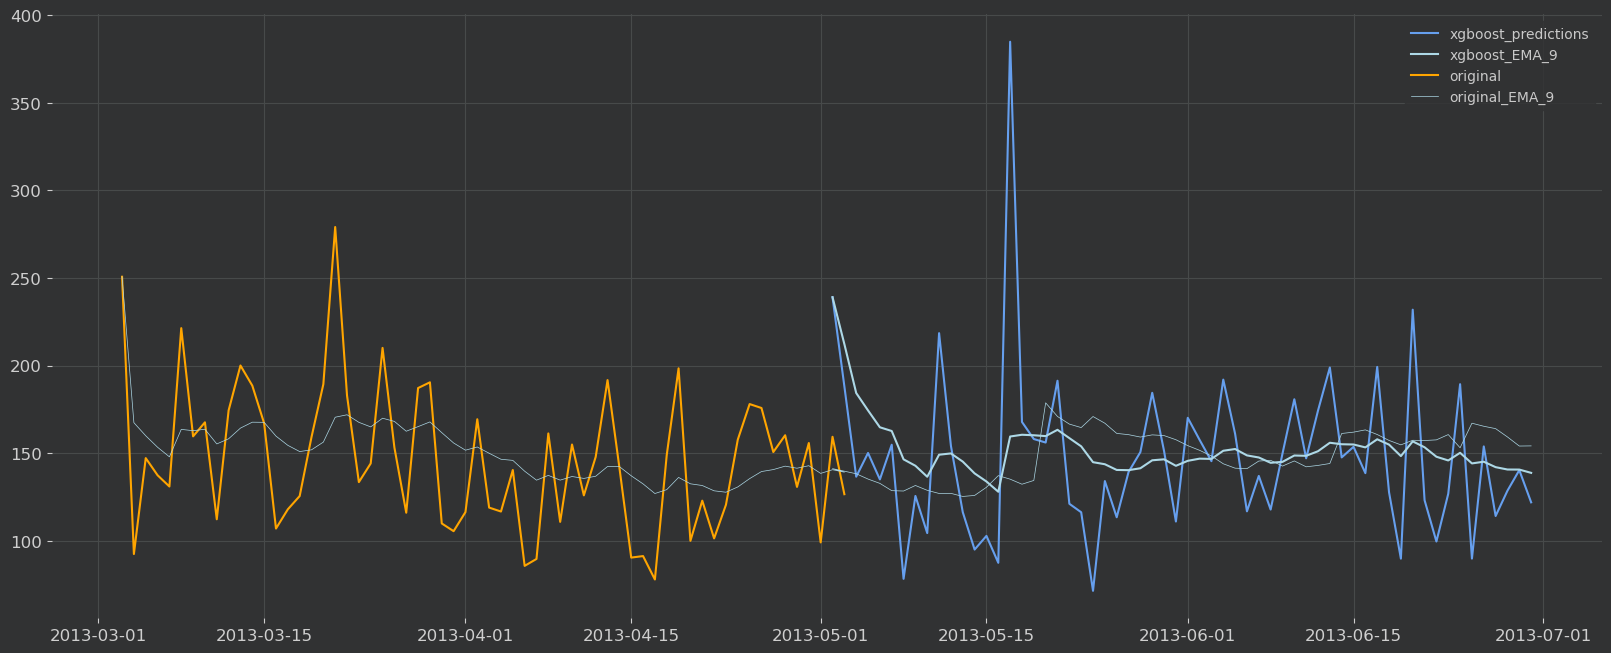

In [29]:
data_view = muestra[[umbral]].iloc[umbral_2*-2:-(umbral_2 + int(-0.0334*umbral_2))]
fig, ax = plt.subplots(figsize=(20,8), dpi=100)
ax.plot(y_pred_real, label='xgboost_predictions')
ax.plot(y_pred_real.ewm(9).mean(), label='xgboost_EMA_9', color='lightblue')
ax.plot(data_view, label='original', color='orange')
ax.plot(pd.concat([data_view, y_test_real]).ewm(9).mean(), label='original_EMA_9', color='lightblue', linewidth=0.5)
plt.legend(loc='best')

### DIFERENCIACION SMART SERIES

**PROCESOS DE DIFERENCIACION STANDARD**

Desarrollamos 3 procesos de diferenciacion, primero y para todos, aplicamos transformacion logaritmica sobre la variable target.

El primer proceso es: log - log.SMA(12)

El segundo proceso es: log - log.EMA(12)

el tercer proceso es: log - log.shift()

<br>

Una vez obtenidos los valores del test de Dick-Fuller sobre los 3 procesos seleccionamos el que devuelva un p-value menor.

Así procedemos a optimizar el proceso de diferenciacion resultante (Solo para el primer y segundo proceso).

Se crea una iteración entre distintos valores de medias moviles y se elije la cantidad de pasos backward que devuelven la mejor curva respecto a una respuesta estacionaria.

	DIFFERENTIATION  PROCESS
Selected Method: EMA
Optimized Params: 5



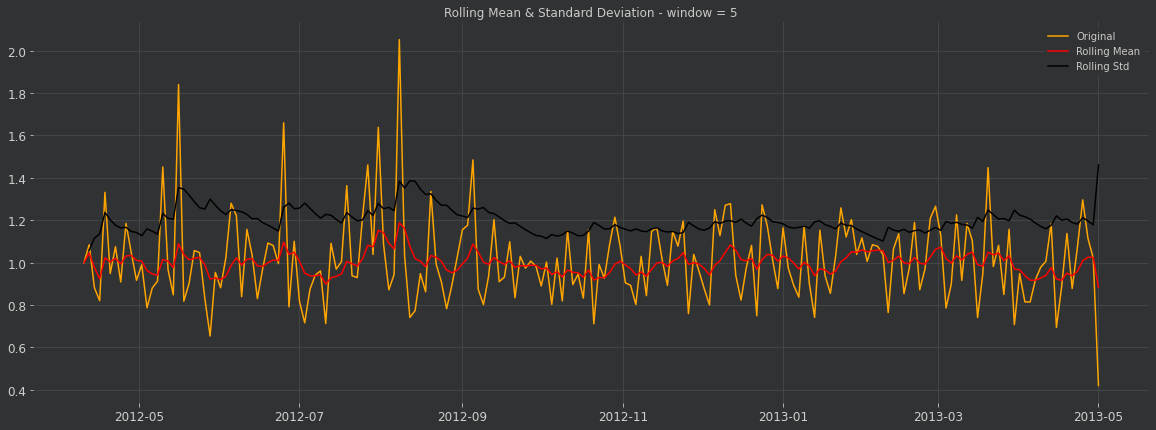

	DICKEY-FULLER TEST
ADF Statistic: -13.467993036870597
p-value: 3.426302209517956e-25
Critical Values:
	1%: -3.4646940755442612
	5%: -2.8766348847254934
	10%: -2.5748163958763994


In [30]:
diferenciacion = arima.test_stationarity(df_train[umbral].resample('2d').sum())

eval_resid_EMA = False
if eval_resid_EMA:
    arima.params_set_plot(diferenciacion)


In [31]:
## lo vamos a sacar celda 17
EMA_log_test = df_train['log_'+umbral].ewm(9).mean()


error_EMA, df_test_EMA, df_pred_EMA = xgb.walk_forward_validation(EMA_log_test.to_frame(), n_test=60)

df_pred_EMA.columns = [umbral]
df_test_EMA.columns = [umbral]

df_pred_EMA.set_index(df_test.index, inplace=True)
df_test_EMA.set_index(df_test.index, inplace=True)

ema_pred_real = np.exp(df_pred_EMA)
ema_test_real = np.exp(df_test_EMA)

text = 'El RMSE de xgboost_EMA(9) = {}'

print(text.format(np.sqrt(mean_squared_error(ema_pred_real, ema_test_real)))) # real porque predice sobre el logaritmo

100%|██████████| 60/60 [00:12<00:00,  4.81it/s]

El RMSE de xgboost_EMA(9) = 5.39079736639984


**AÑADIMOS A LA PREDICCION DE LA EMA LA PREDICCION DEL MODELO REG_LOG_EST**

In [32]:
display(check_optimized_model(results_reg_log_est, umbral_3))

reg_test_real = df_test[[umbral]]
reg_pred_real = np.exp(optimized_umbral_model.predict(df_test)).to_frame()

reg_test_real.columns = [umbral]
reg_pred_real.columns = [umbral]

text = 'El RMSE de reg_log_est({}) = {}'
print(text.format(umbral, np.sqrt(mean_squared_error(reg_pred_real, reg_test_real)))) # real porque predice sobre el logaritmo

,Modelo,RMSE
1,log_trend_est_sq,66.2502


El RMSE de reg_log_est(Bakery) = 66.2502186356703


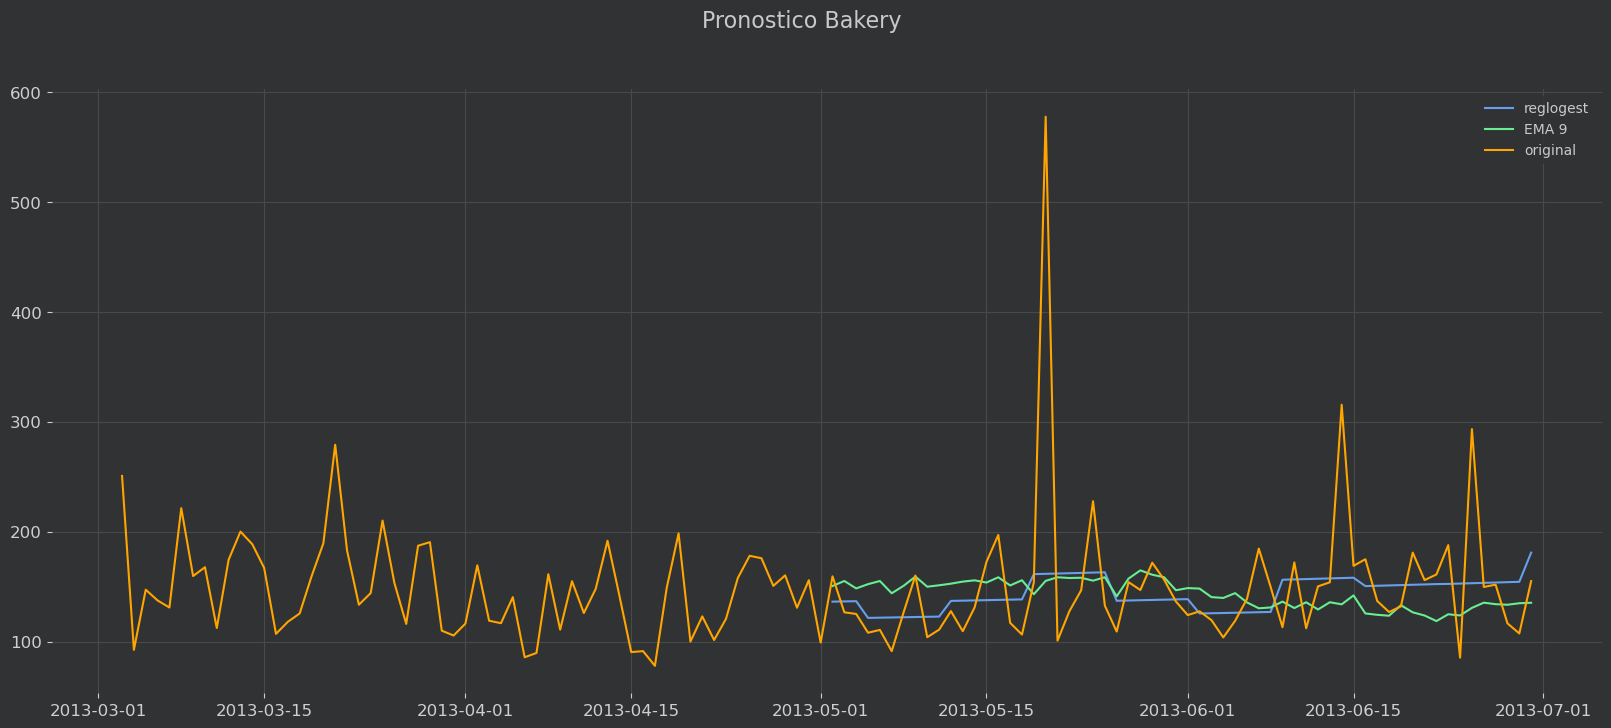

In [33]:
fig, ax = plt.subplots(figsize=(20,8), dpi=100)
fig.suptitle('Pronostico {}'.format(umbral), size=16)
ax.plot(reg_pred_real, label='reglogest')#resample('2d').sum()
ax.plot(ema_pred_real, label='EMA 9')
ax.plot(muestra[[umbral]].iloc[-umbral_2*2:], label='original', color='orange')#resample('2d').sum()
plt.legend(loc='best');

El RMSE de reg_log_est(Bakery) + EMA(9) = 10.679609416717732


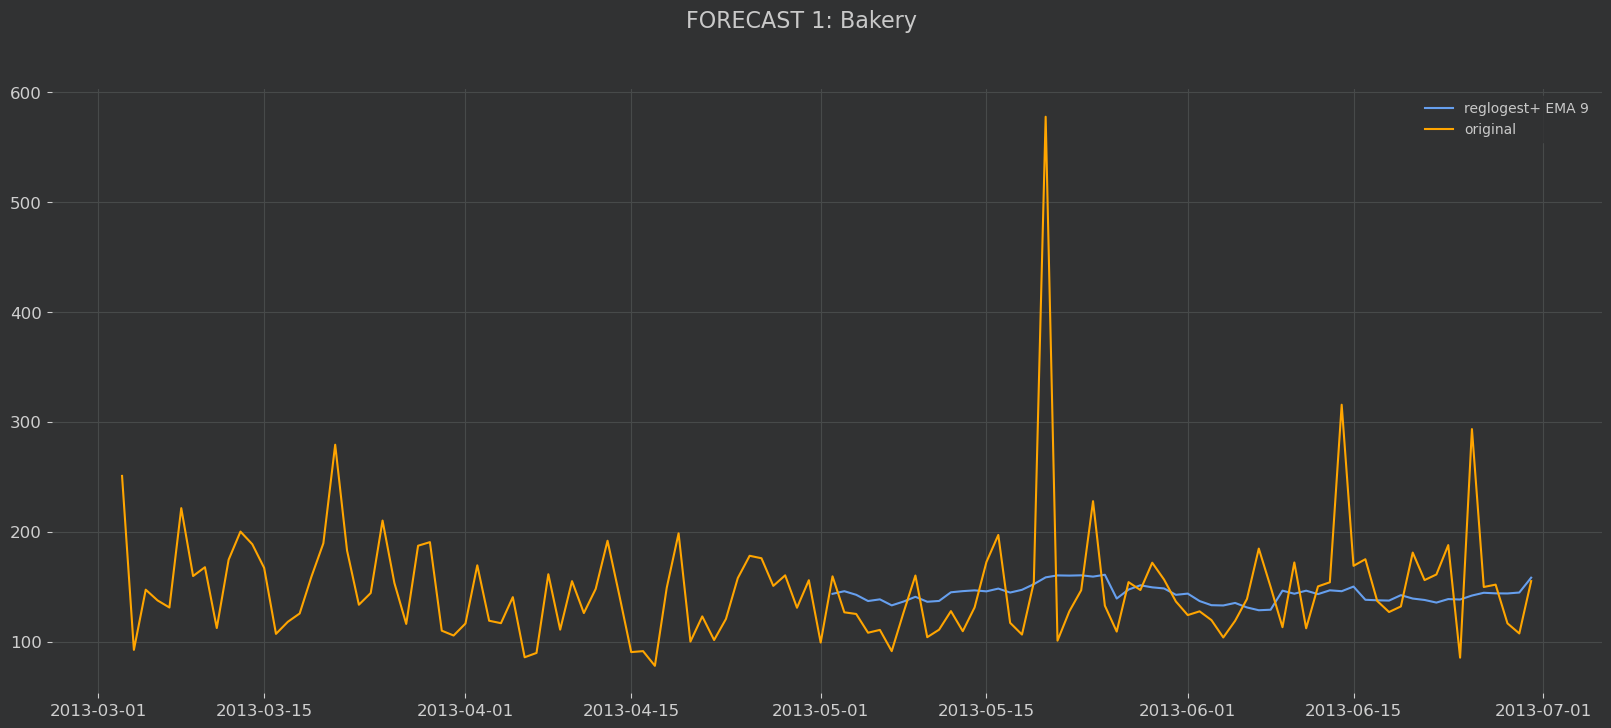

In [34]:
suma_promedio = (reg_pred_real+ema_pred_real)/2
text = 'El RMSE de reg_log_est({}) + EMA(9) = {}'
print(text.format(umbral, np.sqrt(mean_squared_error(reg_pred_real, suma_promedio)))) # real porque predice sobre el logaritmo

fig, ax = plt.subplots(figsize=(20,8), dpi=100)
plt.suptitle('FORECAST 1: {}'.format(umbral), size=16)
ax.plot(suma_promedio, label='reglogest+ EMA 9')#resample('2d').sum()
ax.plot(muestra[[umbral]].iloc[-umbral_2*2:], label='original', color='orange')#resample('2d').sum()
plt.legend(loc='best');

# EJECUCION AUTOMATICA DEL CODIGO

## FORECAST 2: REAL SET

## DEPLOY DE MODELOS


**tratamiento index**

**train test split y almacenamiento de datos para xgboost**

**cross validation y almacenamiento de los datos para reg_log_est**

**forecast xgboost, y estudio de estacionalidad, optimización del proceso de diferenciacion**

**desarrollo de modelos de reg_log_est y exportacion de los modelos entrenados**

**tratamiento de los datos y visualizacion**

**bonus** 

"""
from APP_XGBOOST.py import *
guardar_funcion()

obtiene: 

walk_foreward_validation(timeserie, n_test)
"""

Referencias:

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

material extra para clasificadores:
https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split
https://scikit-learn.org/stable/modules/grid_search.html#grid-search

In [35]:
def create_label(i):
            if i == 0: return 'Jul-Ago'
            if i == 1: return 'Sep-Oct'
            if i == 2: return 'Nov-Dic'

In [36]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit

k = 6 // 2 # meses divido 2, calculo bimestral for real
spliter = TimeSeriesSplit(n_splits=k)
#spliter2 = TimeSeriesSplit(n_splits=4, test_size=None, gap=0, max_train_size=None)
#spliterv2 = TimeSeriesSplit(n_splits=30, test_size=None)# 

In [37]:
activate_xgboost=True

labels_category = list(vectores.keys())

# visualize data
for i, key in enumerate(labels_category):
    if i == 3: pass#display (vectores[key])#, print (vectores[key].index)

# train test split
vectores_downsampling = {}
features = {}
targets = {}
Xs = {}
XXs = {}
xgboost_differentiation_study_dict = {}
for i, key in enumerate(labels_category):
    logger.warning('{}) Funciona mejor sin downsampling, aunque el train test no resulta favorable. Tira problemas de TimeRunOut con downsampling, pero no en todas las categorias, así que para la aplicacion de xgboost que es necesario el downsampling veremos de extraer una muestra para ponerlo a prueba')
    vectores_downsampling[key] = vectores[key]#.resample('2d').sum()
    
    # Encontrar el valor de un año atras y un dia adelante
    last_test_index = vectores_downsampling[key].index[-1]
    index_last_year = last_test_index + pd.offsets.DateOffset(years=-1, days=1)
    
    # encontrar el ultimo dia del año
    index_end_last_year = dt.date(year= index_last_year.year, month=12, day=31) 
    
    # encontrar el primer dia del año siguiente
    index_new_year = index_end_last_year + pd.offsets.DateOffset(days=1)

    # armar el rango real set y el rango de test set
    real_set = vectores_downsampling[key].loc[index_last_year: index_end_last_year]
    test_set = vectores_downsampling[key].loc[index_new_year:]

    # sumarle un año al real_set
    real_set_index = real_set.index + pd.offsets.DateOffset(years=1)
    real_set.set_index(real_set_index, inplace=True)
    new_set = pd.concat([test_set, real_set])

    # Armar el primer train_test_split, y almacenamiento xgboost
    test_size = int(len (real_set) / k + len (real_set))
    X, y = train_test_split(new_set, test_size=test_size, shuffle=False)
    Xs[key] = pd.concat([X[key], y.loc[:last_test_index, key]])
    XXs[key] = new_set
    
    #cross validation time serie
    feature = []
    target = []
    for train_index, test_index in spliter.split(y.index):
        concat_index, predict_index = y.index[train_index], y.index[test_index]
        feature.append(pd.concat([X, y.loc[concat_index]]))
        target.append(y.loc[predict_index])

    # extraemos la data
    features[key] = feature
    targets[key] = target

    # modulo de prediccion xgboost
    if activate_xgboost:
        xgboost_preds = {}
        print ('>> Bucle Forecast + x2 Diferenciacion Estandar - {}'.format(key))
        print ('\t XGBOOST WALK-FOREWARD')
        error, df_test_xgb, df_pred_xgb = xgb.walk_forward_validation(XXs[key]['log_'+key].to_frame(), n_test=len(real_set))
        df_pred_xgb.columns = [key]
        df_pred_xgb.set_index(real_set.index, inplace=True)
        df_pred_xgb = np.exp(df_pred_xgb)
        merged_data = pd.concat([Xs[key].to_frame(), df_pred_xgb])
        
        print ('diferenciacion real + forecast')
        all_dif_value = arima.test_stationarity(merged_data, visualize=False, get=True)
        print ('diferenciacion forecast')
        xgb_dif_value = arima.test_stationarity(df_pred_xgb, visualize=False, get=True)
    
        all_process = list(all_dif_value.keys())[0]
        all_values = list(all_dif_value.values())[0]
        xgb_process = list(xgb_dif_value.keys())[0]
        xgb_values = list(xgb_dif_value.values())[0]

        if all_process != None:
            if all_process == 'SMA':
                merged_data.loc[:, 'SMA_{}_r+f'.format(all_values)] = merged_data.rolling(all_values).mean().dropna()
            if all_process == 'EMA':
                merged_data.loc[:, 'EMA_{}_r+f'.format(all_values)] = merged_data.ewm(all_values).mean().dropna()
        
        if xgb_process != None:
            if xgb_process == 'SMA':
                merged_data.loc[:, 'SMA_{}_f'.format(xgb_values)] = merged_data.rolling(xgb_values).mean().dropna()
            if xgb_process == 'EMA':
                merged_data.loc[:, 'EMA_{}_f'.format(xgb_values)] = merged_data.ewm(xgb_values).mean().dropna()
        
        xgboost_preds['forecast_xgb'] = df_pred_xgb
        xgboost_preds[key+'_'+all_process+'_'+str(all_values)+'_all'] = merged_data.drop(columns=key)
    xgboost_differentiation_study_dict[key] = xgboost_preds


>> Bucle Forecast + x2 Diferenciacion Estandar - Grocery
	 XGBOOST WALK-FOREWARD


100%|██████████| 184/184 [00:38<00:00,  4.82it/s]


diferenciacion real + forecast
	DIFFERENTIATION  PROCESS
Selected Method: EMA
Optimized Params: 5

diferenciacion forecast
	DIFFERENTIATION  PROCESS
Selected Method: EMA
Optimized Params: 3

>> Bucle Forecast + x2 Diferenciacion Estandar - Pharmaceutical
	 XGBOOST WALK-FOREWARD


100%|██████████| 184/184 [00:38<00:00,  4.75it/s]


diferenciacion real + forecast
	DIFFERENTIATION  PROCESS
Selected Method: EMA
Optimized Params: 5

diferenciacion forecast
	DIFFERENTIATION  PROCESS
Selected Method: SMA
Optimized Params: 9

>> Bucle Forecast + x2 Diferenciacion Estandar - Natural_Products
	 XGBOOST WALK-FOREWARD


100%|██████████| 184/184 [00:39<00:00,  4.69it/s]


diferenciacion real + forecast
	DIFFERENTIATION  PROCESS
Selected Method: EMA
Optimized Params: 5

diferenciacion forecast
	DIFFERENTIATION  PROCESS
Selected Method: SMA
Optimized Params: 12

>> Bucle Forecast + x2 Diferenciacion Estandar - Bakery
	 XGBOOST WALK-FOREWARD


100%|██████████| 184/184 [00:42<00:00,  4.28it/s]


diferenciacion real + forecast
	DIFFERENTIATION  PROCESS
Selected Method: EMA
Optimized Params: 12

diferenciacion forecast
	DIFFERENTIATION  PROCESS
Selected Method: EMA
Optimized Params: 15

>> Bucle Forecast + x2 Diferenciacion Estandar - Meat
	 XGBOOST WALK-FOREWARD


100%|██████████| 184/184 [00:41<00:00,  4.47it/s]


diferenciacion real + forecast
	DIFFERENTIATION  PROCESS
Selected Method: EMA
Optimized Params: 15

diferenciacion forecast
	DIFFERENTIATION  PROCESS
Selected Method: EMA
Optimized Params: 9



In [38]:
check = False

if check:
    for i, key in enumerate(labels_category):
        for j in range(len(features[key])):
            display (features[key][j])

In [39]:
nombre_modelos = reg.def_models()

check_scores=False

optimized_deployed_models = {}
name_deployed_models = {}
scores_deployed_models = {}
predictions_deployed_models = {}
for ix, key in enumerate(labels_category):
    # results
    models_dm = []
    names_dm = []
    scores_dm = []
    predictions_dm = []
    for j in range(len(features[key])):

        # variable que utilizamos
        frame = features[key][j]
        target = targets[key][j]

        # creamos los vectores
        vector = SmartSeries.VectorBuilder(frame)
        vector.create()
        vector.treatment()
        vector.dummy('W')

        # instanciamos y entrenamos los modelos
        modelos = reg.available_models()
        for i in range(len(modelos)):
            modelos[i] = modelos[i](frame, vector).fit()

        # predecimos con los modelos y evaluamos los scores de los modelos
        scores = []
        predictions = []
        for i in range(len(modelos)):
            y_pred = modelos[i].predict(target)
            if i >= 3: y_pred = np.exp(y_pred)
            scores.append(np.sqrt(metrics.mean_squared_error(target[key], y_pred)))
            predictions.append(y_pred)

        # disponibilizamos scores sobre los modelos
        result_deployed_models = pd.DataFrame([nombre_modelos, scores]).T
        result_deployed_models.columns = ['Modelo_'+key+'_'+str(j+1), umbral_3]
        check_name = check_optimized_model(result_deployed_models,umbral_3)
        if check_scores : display (result_deployed_models)

        # optmizamos el modelo
        optimized_deployed_model = get_optimized_model(modelos, scores)
        prediction_deployed_model = predictions[list(check_optimized_model(result_deployed_models, umbral_3).index)[0]].to_frame()
        prediction_deployed_model.columns = [key]

        # almacenamos la data
        models_dm.append(optimized_deployed_model)
        names_dm.append(check_name.iloc[0].values[0])
        scores_dm.append(result_deployed_models)
        predictions_dm.append(prediction_deployed_model)

        # exportamos los modelos
        text = 'fitted_{}{}_{}'
        SmartSeries.save_object(optimized_deployed_model, text.format(key, j+1, create_label(j)))


    # exportamos la data
    optimized_deployed_models[key] = models_dm
    name_deployed_models[key] = names_dm
    scores_deployed_models[key] = scores_dm
    predictions_deployed_models[key] = predictions_dm


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date



## visualizacion


In [40]:
# concat each fold prediction in one dataset
predictions_deployed_models_merged = {}
for i, key in enumerate(list(predictions_deployed_models.keys())):
    data_merged = pd.DataFrame()
    for j in range(len(predictions_deployed_models[key])):
        data_merged = pd.concat([data_merged, predictions_deployed_models[key][j]])
    predictions_deployed_models_merged[key] = data_merged

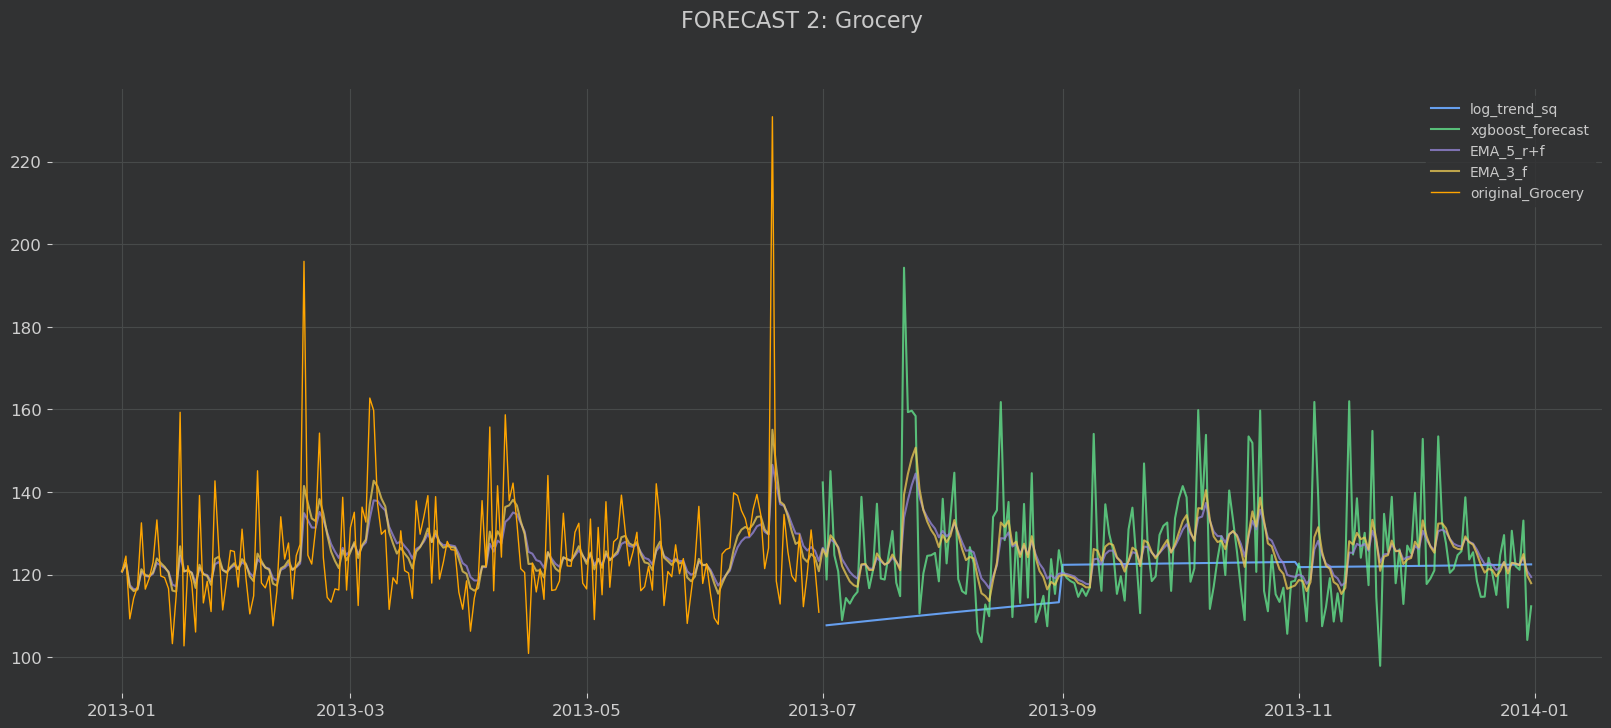

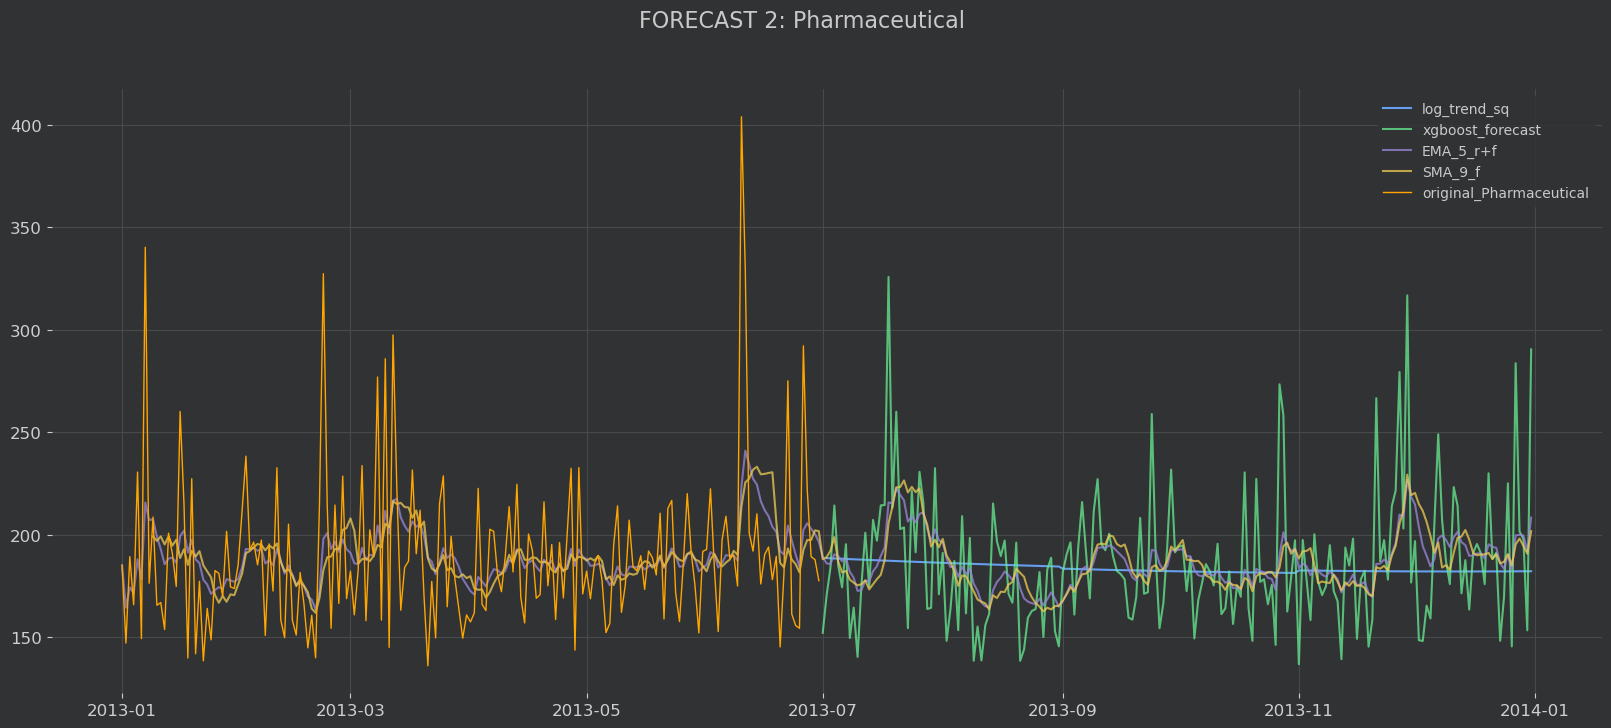

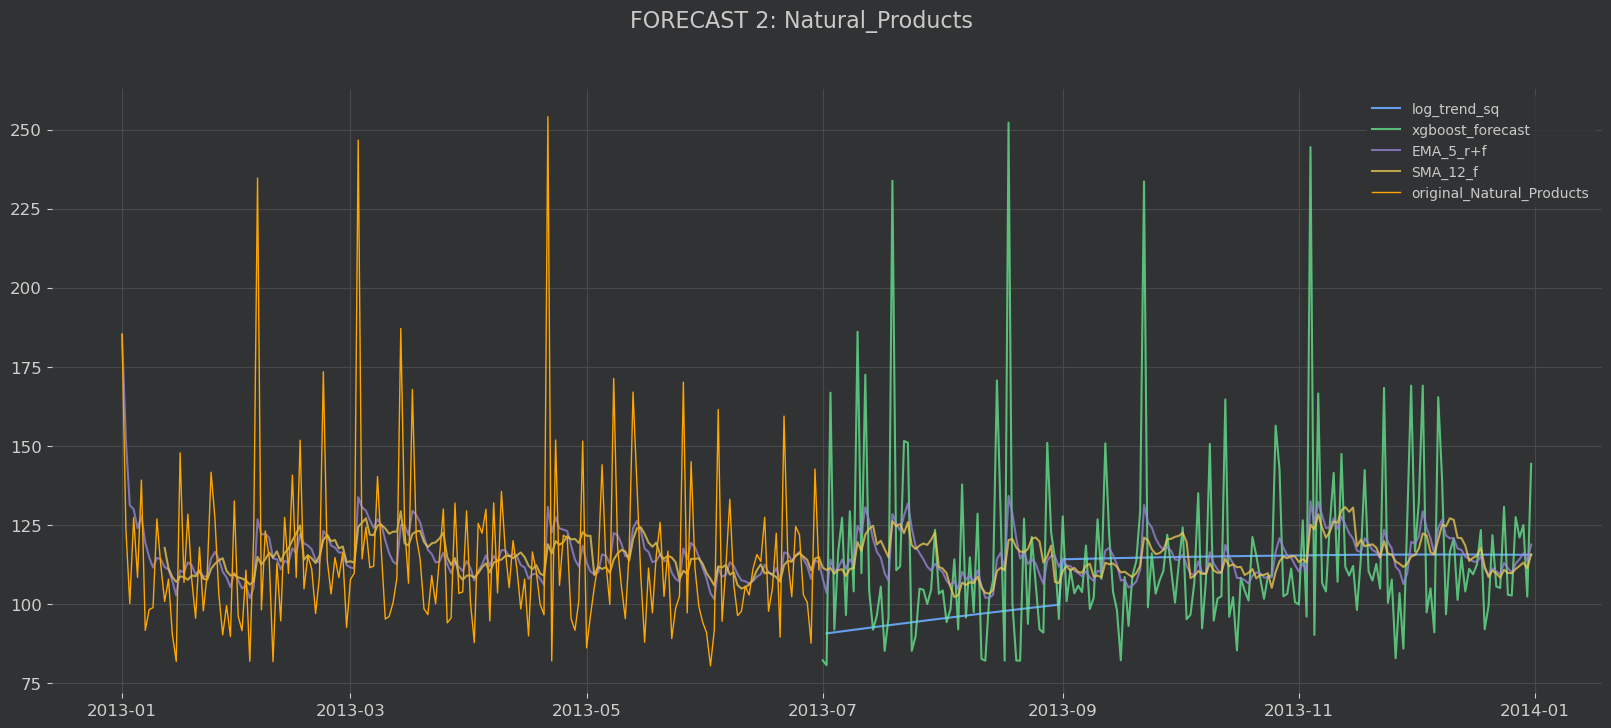

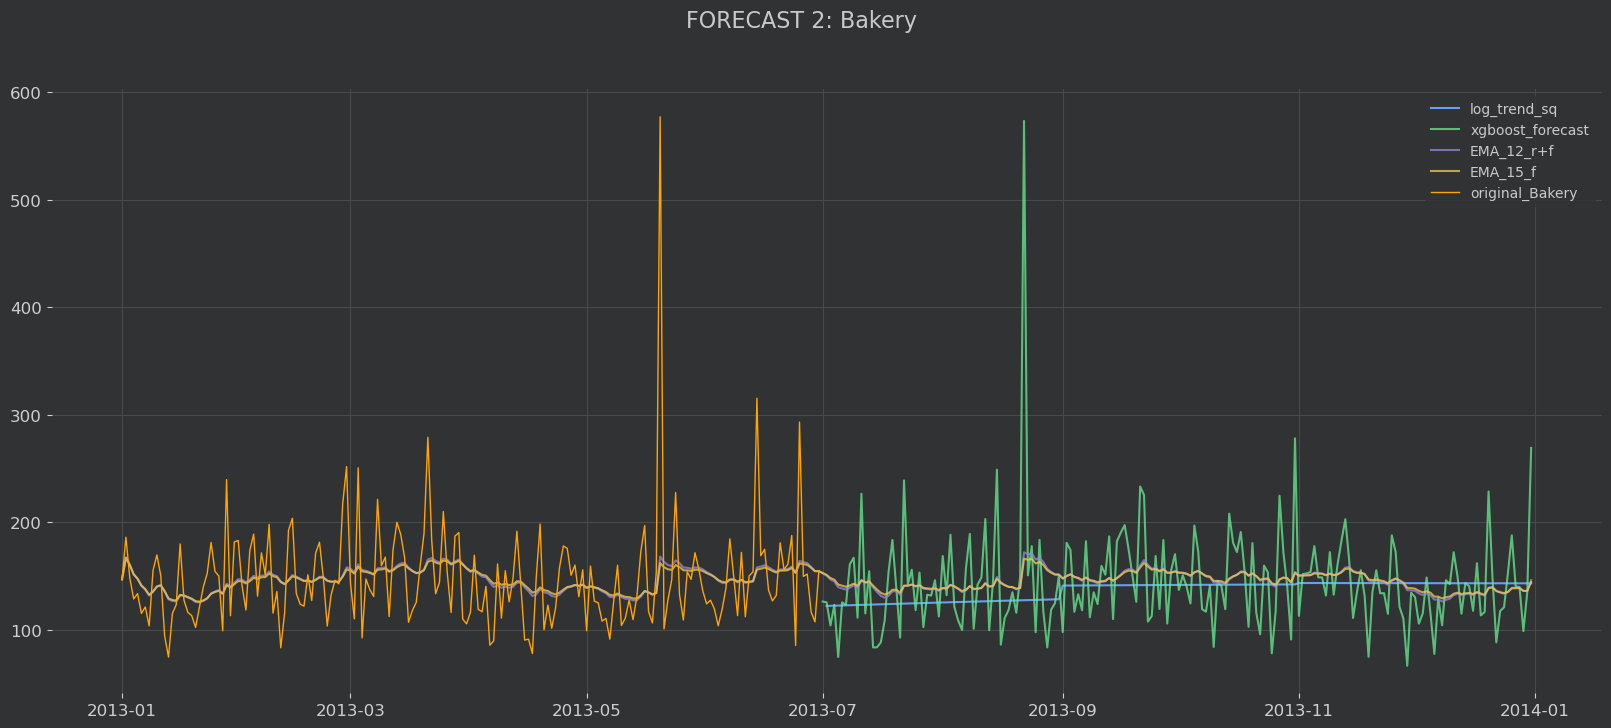

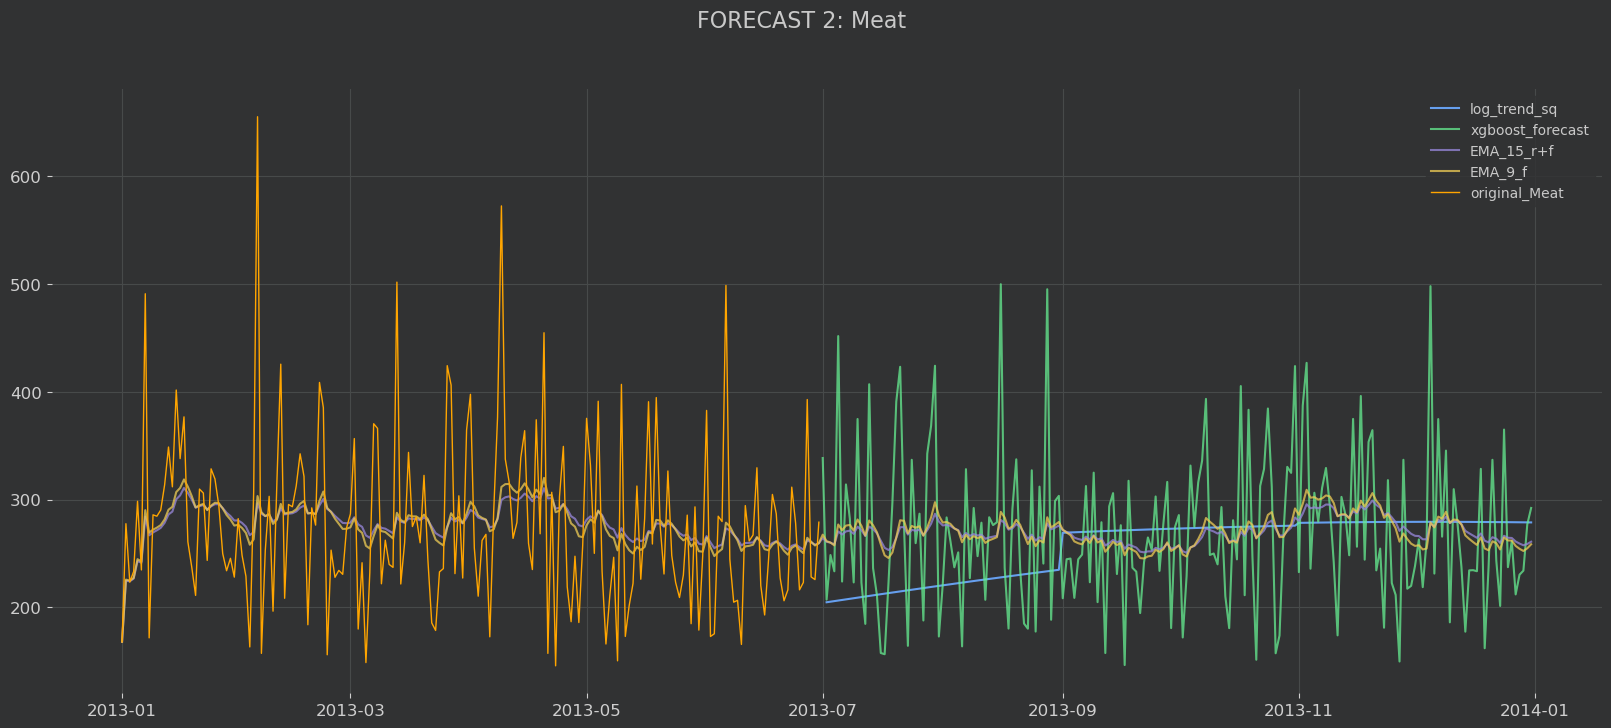

In [41]:
# visualize

for i, key in enumerate(list(predictions_deployed_models.keys())):
    fig, ax = plt.subplots(figsize=(20,8), dpi=100)
    fig.suptitle('FORECAST 2: {}'.format(key), size=16)
    ax.plot(predictions_deployed_models_merged[key], label=list(set(name_deployed_models[key]))[0])
    
    for j, sub_key in enumerate(xgboost_differentiation_study_dict[key].keys()):
        if j == 0: ax.plot(xgboost_differentiation_study_dict[key][sub_key], label='xgboost_forecast', alpha=0.75)
        else: ax.plot(xgboost_differentiation_study_dict[key][sub_key], label=xgboost_differentiation_study_dict[key][sub_key].columns, alpha=0.75)

    ax.plot(Xs[key], label='original_{}'.format(key), color='orange', linewidth=1)

    plt.legend(loc='best');

In [42]:
#que pasa si entreno un modelo para primera quincena de mayo segunda quincena de mayo, primera quincena de junio, segunda quincena de junio
import statsmodels 

statsmodels.__version__

'0.13.2'

**CONCLUSIONES**